In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [9]:
from langgraph.graph import StateGraph, END 
from typing import TypedDict, List
from langgraph.checkpoint.sqlite import SqliteSaver 
from langchain_core.messages import SystemMessage, HumanMessage

from prompts import *

memory = SqliteSaver.from_conn_string(":memory:")

In [5]:
class AgentState(TypedDict):
    query: str 
    definition: str 
    decomposed_steps: List[str]
    solved_steps: List[str]
    completed_step: int

In [38]:
from langchain_core.pydantic_v1 import BaseModel
from langchain.output_parsers import PydanticOutputParser

class Steps(BaseModel):
    steps: List[str]

In [11]:
def problem_definer_node(state: AgentState):
    messages = [
        SystemMessage(content=PROBLEM_DEFINER_PROMPT),
        HumanMessage(content=state['query'])
    ]
    response = llm.invoke(messages)
    return {"definition": response.content}

In [48]:
parser = PydanticOutputParser(pydantic_object=Steps)
    
chain = llm | parser
system_message = f"{PROBLEM_DECOMPOSER_PROMPT}\n\nFormat Instructions: {parser.get_format_instructions()}"
    
messages = [
        SystemMessage(content=system_message),
        HumanMessage(content="Solve for x and y in the equations x + y = 10 and 2x - y = 4.")
    ]
    
print(type())
steps = parser.parse(chain.invoke(messages))

ValidationError: 1 validation error for Generation
text
  str type expected (type=type_error.str)

In [49]:
resp = chain.invoke(messages)

In [50]:
print(type(resp))

<class '__main__.Steps'>


In [51]:
resp.steps

["**Step 1: Solve for one variable in terms of the other.** Choose one of the equations and solve for either x or y. For this example, let's solve the first equation (x + y = 10) for x:  x = 10 - y",
 '**Step 2: Substitute the expression.** Substitute the expression you just derived (x = 10 - y) into the second equation (2x - y = 4) in place of x: 2(10 - y) - y = 4',
 '**Step 3: Simplify and solve for y.** Distribute the 2: 20 - 2y - y = 4. Combine like terms: 20 - 3y = 4. Subtract 20 from both sides: -3y = -16. Divide both sides by -3: y = 16/3',
 "**Step 4: Substitute the value of y to solve for x.** Substitute the value of y (16/3) back into either of the original equations. Let's use the first equation (x + y = 10): x + (16/3) = 10",
 '**Step 5: Solve for x.** Subtract (16/3) from both sides: x = 10 - (16/3).  Find a common denominator: x = (30/3) - (16/3). Simplify: x = 14/3',
 '**Solution:** The solution to the system of equations is x = 14/3 and y = 16/3.']

In [52]:
def problem_decomposer_node(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=Steps)
    
    chain = llm | parser
    system_message = f"{PROBLEM_DECOMPOSER_PROMPT}\n\nFormat Instructions: {parser.get_format_instructions()}"
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=state['definition'])
    ]
    
    steps = chain.invoke(messages)
    return {"decomposed_steps": steps.steps}

In [19]:
def step_generator(state: AgentState):
    solved_steps = state['solved_steps'] or []
    step_count = state.get("completed_steps", 0)
    while step_count != len(state['decomposed_steps']):
        content = "\n\n".join(solved_steps)
        human_content = f"This is the solution so far: {content}\n\n and this is the description for next step: {state['decomposed_steps'][step_count]}"
        
        messages = [
            SystemMessage(content=STEP_GENERATOR_PROMPT),
            HumanMessage(content=human_content)
        ]
        response = llm.invoke(messages)
        solved_steps.append(response.content)
        step_count += 1
    
    return {
        "solved_steps": solved_steps, 
        "completed_steps": step_count
    }

In [53]:
builder = StateGraph(AgentState)

In [54]:
builder.add_node("definer", problem_definer_node)
builder.add_node("decomposer", problem_decomposer_node)
builder.add_node("solver", step_generator)

In [55]:
builder.set_entry_point("definer")

In [56]:
builder.add_edge("definer", "decomposer")
builder.add_edge("decomposer", "solver")
builder.add_edge("solver", END)

In [57]:
graph = builder.compile(checkpointer=memory)

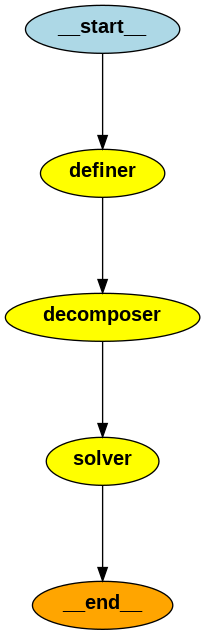

In [58]:
from IPython.display import Image 

Image(graph.get_graph().draw_png())

In [59]:
thread = {"configurable": {"thread_id": 1}}

response = graph.invoke({"query": "What is the solution for x in sin(x)^3 - cos(x) = 4?"}, thread)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


In [63]:
print("\n\n".join(response['solved_steps']))

Excellent!  Now that we have our equation, let's see if we can make it easier to work with. 

Our current equation likely has a mix of trigonometric functions like sine, cosine, tangent, etc.  The goal of this simplification step is to see if we can use trigonometric identities to make the equation less complicated.

For example, remember the Pythagorean identity:  sin²(x) + cos²(x) = 1.  If we see something like sin²(x) and cos²(x) in our equation, we can replace them with 1.  This can be a powerful way to reduce the number of terms or even eliminate a trigonometric function entirely.

So, carefully examine the equation you have.  Look for any opportunities to apply known trigonometric identities and simplify.  The aim is to express the equation in the simplest form possible, ideally in terms of just one trigonometric function. 


Okay, we've successfully simplified our equation using trigonometric identities.  That's great! Now, before we dive into more complex solution methods, let'

In [64]:
response['decomposed_steps']

['**Step 1: Simplification:** Attempt to simplify the equation by applying trigonometric identities. Explore possibilities of expressing the equation in terms of a single trigonometric function (e.g., using the Pythagorean identity sin^2(x) + cos^2(x) = 1).',
 '**Step 2: Analyze for Special Cases:** Check if the given equation represents any special trigonometric values or angles that have known solutions (e.g., sin(30°) = 0.5).',
 '**Step 3: Numerical or Graphical Analysis:** If simplification using identities is not straightforward, consider using numerical methods (e.g., graphing calculators, numerical solvers) or graphical analysis to approximate solutions.',
 '**Step 4: Solution Validation:** Substitute the obtained solution(s) back into the original equation to verify if they hold true.',
 '**Step 5: Periodicity Consideration:** Account for the periodic nature of trigonometric functions. Determine all possible solutions within a specified interval or the general solution by addin